In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, norm,gamma
from scipy.special import polygamma
df = pd.read_csv('education_career.csv')

Сравним количество женщин и мужчин, обучающихся на направлениях "Математика" и "Компьютерные науки".

In [13]:
target_specialties = ['Mathematics', 'Computer Science']
target_sex = ['Male', 'Female']
filtered_df = df[df['Field_of_Study'].isin(target_specialties) &
                 df['Gender'].isin(target_sex) ]
gender_count = filtered_df.groupby(['Field_of_Study', 'Gender']).size().unstack()
print(gender_count)

Gender            Female  Male
Field_of_Study                
Computer Science     314   323
Mathematics          347   365


Как мы видим, на обоих направлениях мужчин больше, чем женщин.

Далее выберем параметр среднего балла для анализа.

In [23]:
parameter = 'Starting_Salary'

Найдём выборочное
 среднее, выборочную дисперсию, выборочную медиану и выборочную квантиль порядка
 4/5 выбранного параметра.

$\bar{X}=\frac{1}{n}\sum_{i=1}^{n}x_{i}$ \
$\overline{D}=\overline{X^{2}}-(\overline{X})^{2}$ \
$\tilde{X}_n =
\begin{cases}
X_{\left(\frac{n+1}{2}\right)}, & \text{если } n \text{ нечётное}, \\
\frac{1}{2}\left(X_{\left(\frac{n}{2}\right)} + X_{\left(\frac{n}{2}+1\right)}\right), & \text{если } n \text{ чётное},
\end{cases}$ \
$\hat{x}_{4/5} = X_{(\lceil \frac{4n}{5} \rceil)}$

In [17]:
stats = {
    'Среднее': df[parameter].mean(),
    'Дисперсия': df[parameter].var(),
    'Медиана': df[parameter].median(),
    'Квантиль 4/5': df[parameter].quantile(4/5)
}
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

Среднее: 3.00
Дисперсия: 0.33
Медиана: 2.99
Квантиль 4/5: 3.60


Далее построим график эмпирической функции распределения ЭФР, гистограмму и box-plot параметра для всех студентов и отдельно для каждой возможной комбинации пол-параметр.

In [18]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Эмпирическая функция распределения: \
$\mu_n = \sum\mathbf{I(X_k \leq x})$; $F_n(x) = \frac{\mu_n}{n}$

Text(0, 0.5, 'Вероятность')

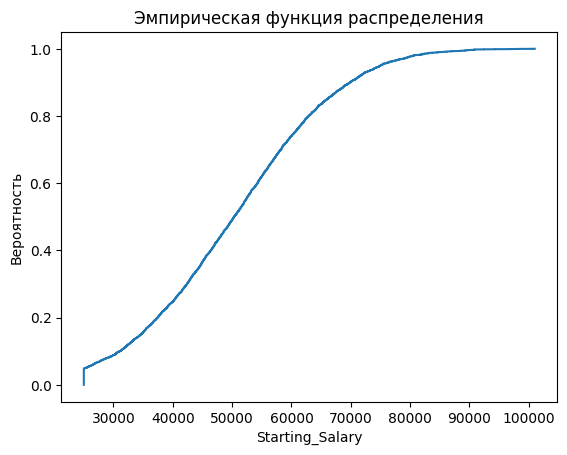

In [27]:
plt.subplot(1, 1, 1)
x = np.sort(df[parameter])
y = np.arange(1, len(x)+1) / len(x)
plt.step(x, y)
plt.title('Эмпирическая функция распределения')
plt.xlabel(parameter)
plt.ylabel('Вероятность')

Гистограмма:

Text(0.5, 0, 'Starting_Salary')

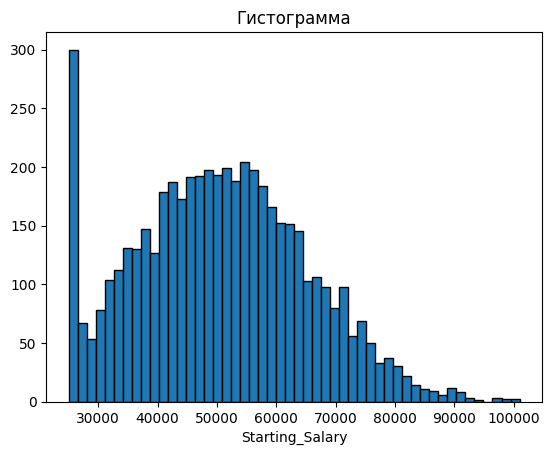

In [30]:
plt.subplot(1, 1, 1)
n_bins = int(len(df)/100)
plt.hist(df[parameter], bins=n_bins, edgecolor='black')
plt.title('Гистограмма')
plt.xlabel(parameter)

Сделаем box-lot для всех студентов

<ipython-input-48-5c72f285966d>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(df['Starting_Salary'], vert=True, patch_artist=True,labels=['Все студенты'])


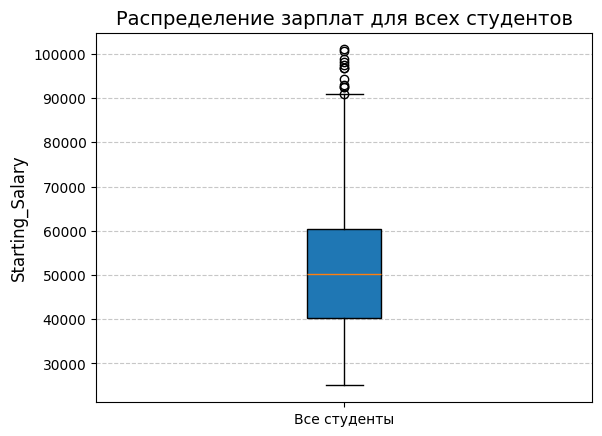

In [48]:
box = plt.boxplot(df['Starting_Salary'], vert=True, patch_artist=True,labels=['Все студенты'])
plt.title('Распределение зарплат для всех студентов', fontsize=14)
plt.ylabel(parameter, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Для каждой возможной комбинации пол-параметр:

<ipython-input-49-730229424b8a>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([male, female, other],vert=True,patch_artist=True,labels=['Male', 'Female', 'Other'])


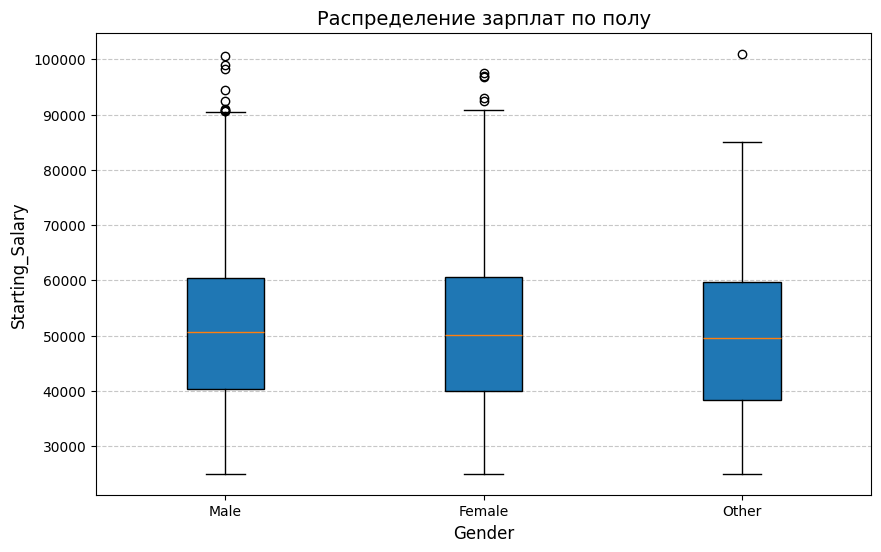

In [49]:
male = df[df['Gender'] == 'Male']['Starting_Salary']
female = df[df['Gender'] == 'Female']['Starting_Salary']
other = df[df['Gender'] == 'Other']['Starting_Salary']
plt.figure(figsize=(10, 6))
box = plt.boxplot([male, female, other],vert=True,patch_artist=True,labels=['Male', 'Female', 'Other'])
plt.title('Распределение зарплат по полу', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel(parameter, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Такие box-plot вызваны распределением зарплат, низким количеством пола с "other". Это также намекает на логнормальное распределение или гамма-распределение, которое часто возникает в зарплатах, где большинство людей получают средние или ниже среднего значения, а небольшое число — очень высокие (длинный правый хвост).

Перейдём к исследованию распределения. Согласно предыдущим рассуждениям и графику эмпирической функции распределения, я предполагаю что это гамма распределение.

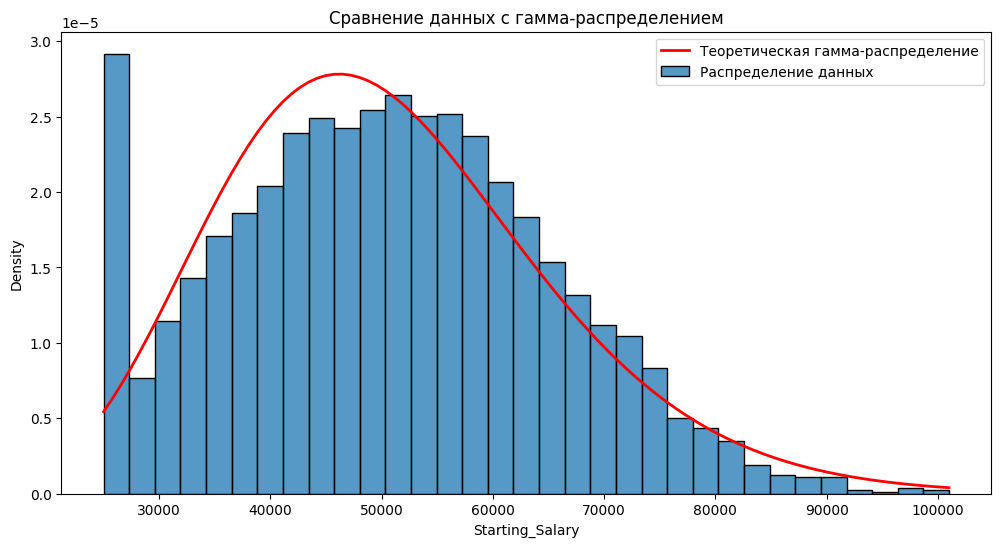

In [64]:
params = gamma.fit(df[parameter], floc=0)
a, loc, scale = params
plt.figure(figsize=(12, 6))
sns.histplot(df['Starting_Salary'], kde=False, stat='density', label='Распределение данных')

x = np.linspace(df['Starting_Salary'].min(), df['Starting_Salary'].max(), 100)
pdf = gamma.pdf(x, a=a, loc=loc, scale=scale)
plt.plot(x, pdf, 'r-', lw=2, label='Теоретическая гамма-распределение')

plt.title('Сравнение данных с гамма-распределением')
plt.xlabel(parameter)
plt.legend()
plt.show()

Как мы видим, это действительно гамма-распределение, с выбросом плотности в низких зарплатах, которое обозначает что много людей полюучают зарплату ближе к минимальному уровню, что соотвествует понятию начальной заработной платы в образовательной карьере.

Для выборки $x_1, x_2, \ldots, x_n$ функция правдоподобия:
$
L(\alpha, \beta) = \prod_{i=1}^n \frac{\beta^\alpha}{\Gamma(\alpha)} x_i^{\alpha-1} e^{-\beta x_i}.
$
\
Логарифмируем для упрощения:
$
\ln L(\alpha, \beta) = n \alpha \ln \beta - n \ln \Gamma(\alpha)                                       +
(\alpha - 1) \sum_{i=1}^n \ln x_i - \beta \sum_{i=1}^n x_i.
$

Производная по $\beta$:
$
\frac{\partial \ln L}{\partial \beta} = \frac{n \alpha}{\beta} - \sum_{i=1}^n x_i = 0 \quad \Rightarrow \quad \beta = \frac{n \alpha}{\sum x_i}.
$

Производная по $\alpha$:
$
\frac{\partial \ln L}{\partial \alpha} = n \ln \beta - n \psi(\alpha) + \sum_{i=1}^n \ln x_i = 0,
$
где $\psi(\alpha) = \frac{d}{d\alpha} \ln \Gamma(\alpha)$ — дигамма-функция.

Выражаем $\beta$ через $\alpha$:
$
\beta = \frac{\alpha}{\bar{x}}, \quad \text{где } \bar{x} = \frac{1}{n} \sum x_i.
$

Подставляем $\beta$ в уравнение для $\alpha$:
$
\ln \alpha - \psi(\alpha) = \ln \bar{x} - \frac{1}{n} \sum \ln x_i.
$ - решим это в Python c помощью встроенных функций


In [81]:
beta = 1/scale
print(f"α = {a}, β = {beta}\n")

α = 11.537135672220227, β = 0.00022817104325014082



Свойства оценок:\
Состоятельность: $\hat{\alpha} \xrightarrow{P} \alpha$, $\hat{\beta} \xrightarrow{P} \beta$ при $n \to \infty =>$ оценки состоятельны.(ММП гарантирует это, т.к выполняются условия регулярности) \
  Асимптотическая нормальность: \
  $
  \sqrt{n} \begin{pmatrix}
  \hat{\alpha} - \alpha \\
  \hat{\beta} - \beta
  \end{pmatrix} \xrightarrow{d} \mathcal{N}\left(0, I^{-1}(\alpha, \beta)\right),
  $
  где $I(\alpha, \beta)$ — информация Фишера => оценка асимптотически нормальная (следует из ЦПТ для функции правдоподобия)
  \
  Информация Фишера:
  $
  I(\alpha, \beta) = \begin{pmatrix}
  \psi'(\alpha) & -\frac{1}{\beta} \\
  -\frac{1}{\beta} & \frac{\alpha}{\beta^2}
  \end{pmatrix},
  $
  $\psi'(\alpha)$ — тригамма-функция.


Теперь найдём дисперсию и MSE: \
 Дисперсия оценок:
  $
  \text{Var}(\hat{\alpha}) \approx \frac{1}{n \cdot \psi'(\alpha)}, \quad \text{Var}(\hat{\beta}) \approx \frac{\beta^2}{n \alpha}.
  $ \
MSE:
  $
  \text{MSE}(\hat{\theta}) = \text{Var}(\hat{\theta}) + \text{Bias}^2(\hat{\theta}) \approx \text{Var}(\hat{\theta}) \quad (\text{для больших } n).
  $
  \
Cмещение:
Для оценок ММП $\hat{\alpha}$ и $\hat{\beta}$:
$
\text{Bias}(\hat{\alpha}) \approx 0, \quad \text{Bias}(\hat{\beta}) \approx 0 \quad (n \to \infty).
$

Для малых выборок: \
Приближённая формула для $\hat{\alpha}$:
$
\text{Bias}(\hat{\alpha}) \approx \frac{1}{2n} \cdot \frac{\alpha}{\psi'(\alpha) - \frac{1}{\alpha}},
$ (выводится через ряд Тейлора)

Найдём теперь дисперсию и информацию Фишера, а также смещение:

In [82]:
I_alpha = polygamma(1, a)
I_beta = a / beta**2
I_matrix = np.array([[I_alpha, -1/beta],
                    [-1/beta, I_beta]])
n = len(df[parameter])
var_alpha = 1 / (n * I_alpha)
var_beta = 1 / (n * I_beta)
bias = 1/(2*n)*a/(I_alpha - 1/a)
print(f"Дисперсия alpha = {var_alpha}, Дисперсия beta = {var_beta}\n")
print(f"Информация Фишера = {I_matrix}")
print(f"Bias(alpha) = {bias}")
print(f"MSE(alpha) = {var_alpha + bias**2}, MSE(beta) = {var_beta + bias**2}")


Дисперсия alpha = 0.002208933905129431, Дисперсия beta = 9.025121391822677e-13

Информация Фишера = [[ 9.05414144e-02 -4.38267707e+03]
 [-4.38267707e+03  2.21603667e+08]]
Bias(alpha) = 0.29851925141778196
MSE(alpha) = 0.09132267737216235, MSE(beta) = 0.08911374346793544
5000


Зафиксируем конкретное значение $\theta = \theta_0$ \
Далее заведём массив ${n_1, ..., n_k}$ объемов выборки \
Сгенерируем из распределения $P_{\theta_0}$ достаточно большое количество M выборок объёма n, где n принимает значения из массива ${n_1, ..., n_m}$. Для каждой сгенерированной выборки вычислим оценку $\hat{\theta}$

 Эмпирически рассмотреть поведение оценки $\hat{\theta}$ в зависимости от объема выборки
 (можно для каждого объема выборки $n_i$ вывести описательные статистики для оценок,
изобразить гистограмму, box-plot, violin-plot).

Зафиксируем значения из прошлого:

In [83]:
alpha_true = a
beta_true = beta
scale = scale

Заведём массив объёмов выборки:

In [96]:
n_values = [100, 500, 1000, 2000, 2500, 5000]
M = 1000

Далее заведём структуру для хранения оценок и функцию для оценки параметров методом максимального правдоподобия:

In [97]:
from scipy.optimize import root_scalar
from scipy.special import digamma
estimates_alpha = {n: [] for n in n_values}
estimates_beta = {n: [] for n in n_values}
def estimate_gamma_params(data):
    n = len(data)
    mean_x = np.mean(data)
    sum_logx = np.sum(np.log(data))
    C = np.log(mean_x) - sum_logx / n

    def equation(alpha):
        return np.log(alpha) - digamma(alpha) - C

    sol = root_scalar(equation, bracket=[0.1, 100], method='brentq')
    alpha_hat = sol.root
    beta_hat = alpha_hat / mean_x
    return alpha_hat, beta_hat

Сгенерируем данные и оценим параметры:

In [98]:
import scipy.stats as stats
for n in n_values:
    for _ in range(M):
        data = stats.gamma.rvs(a=alpha_true, scale=scale,size=n)
        try:
            alpha_hat, beta_hat = estimate_gamma_params(data)
            estimates_alpha[n].append(alpha_hat)
            estimates_beta[n].append(beta_hat)
        except:
            continue

Гистограммы для alpha:

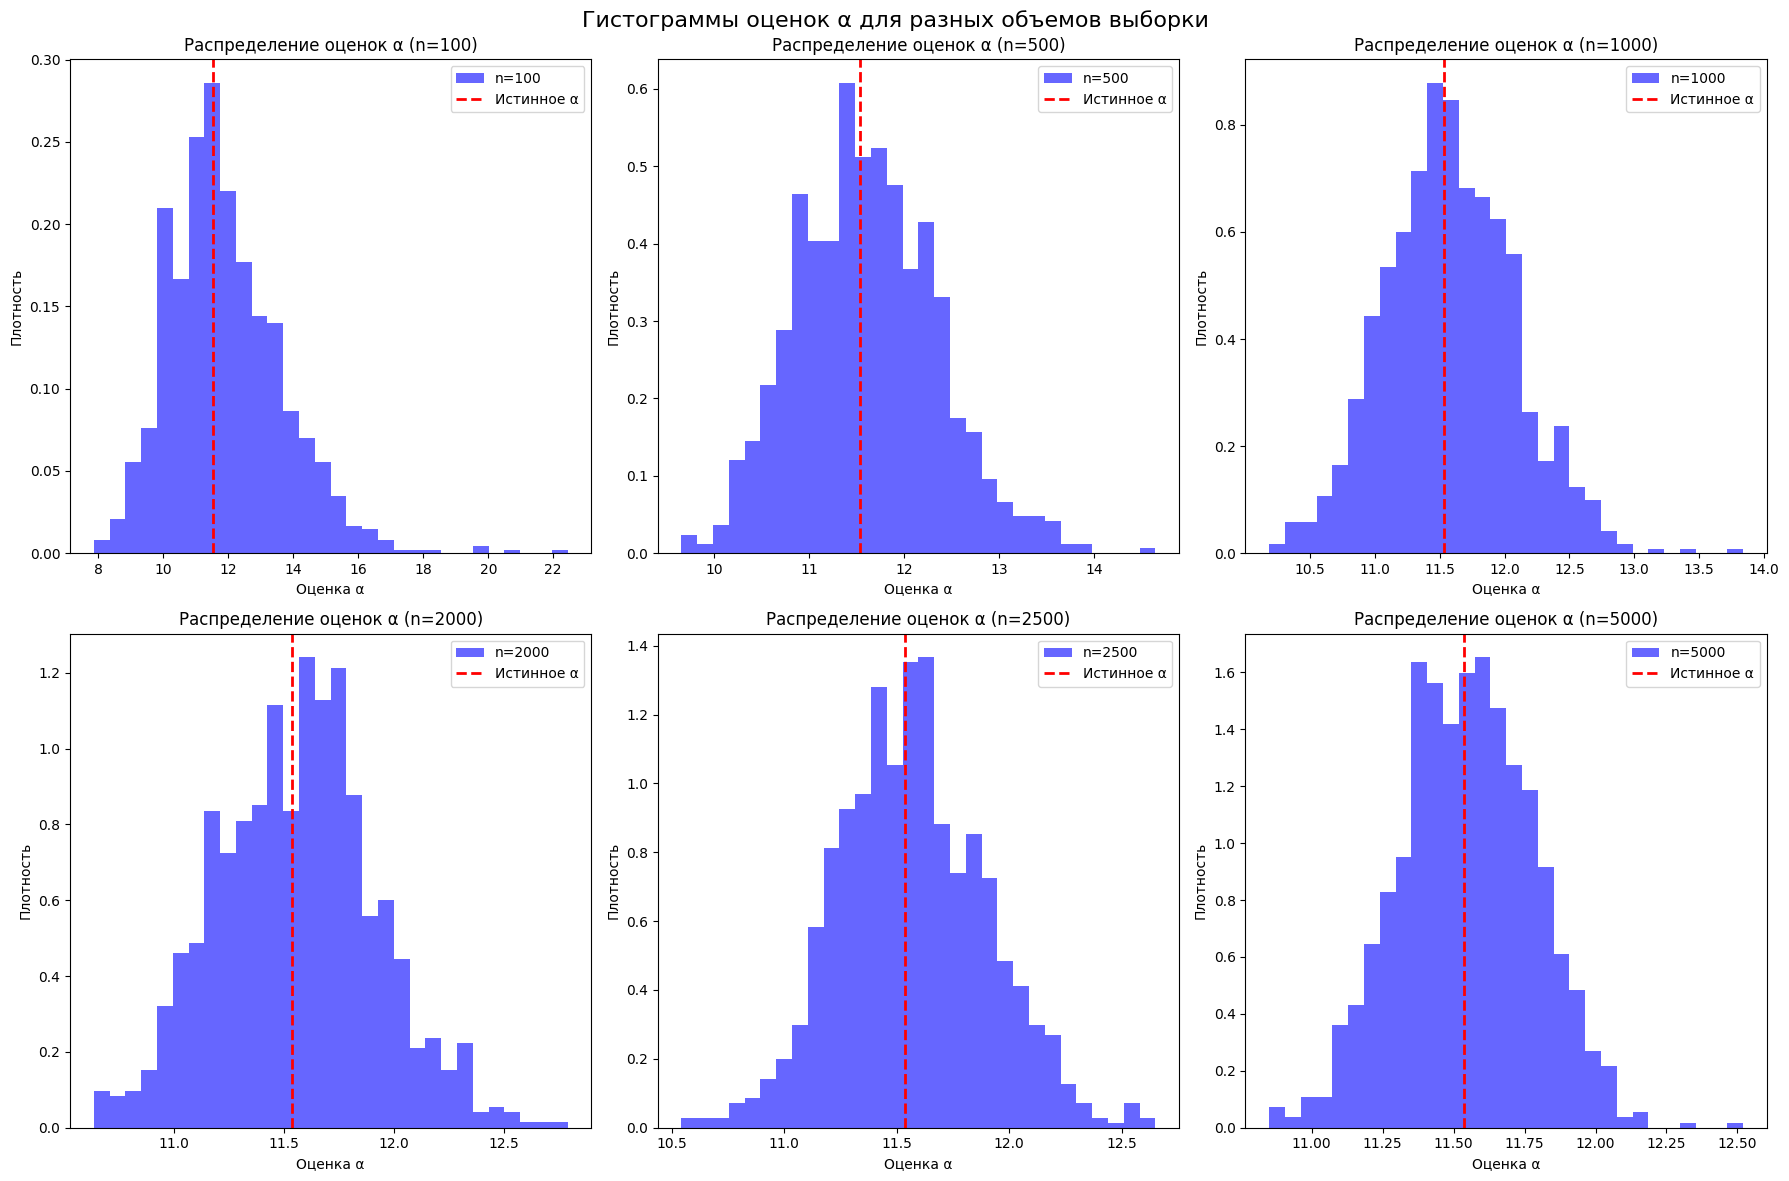

In [99]:
plt.figure(figsize=(18, 12))

for i, n in enumerate(n_values, 1):
    plt.subplot(2, 3, i)
    plt.hist(estimates_alpha[n], bins=30, density=True, alpha=0.6, color='blue', label=f'n={n}')
    plt.axvline(alpha_true, color='red', linestyle='--', linewidth=2, label='Истинное α')
    plt.title(f'Распределение оценок α (n={n})', fontsize=12)
    plt.xlabel('Оценка α', fontsize=10)
    plt.ylabel('Плотность', fontsize=10)
    plt.legend()

plt.suptitle('Гистограммы оценок α для разных объемов выборки', fontsize=16)
plt.tight_layout()
plt.show()

box-plot для alpha:

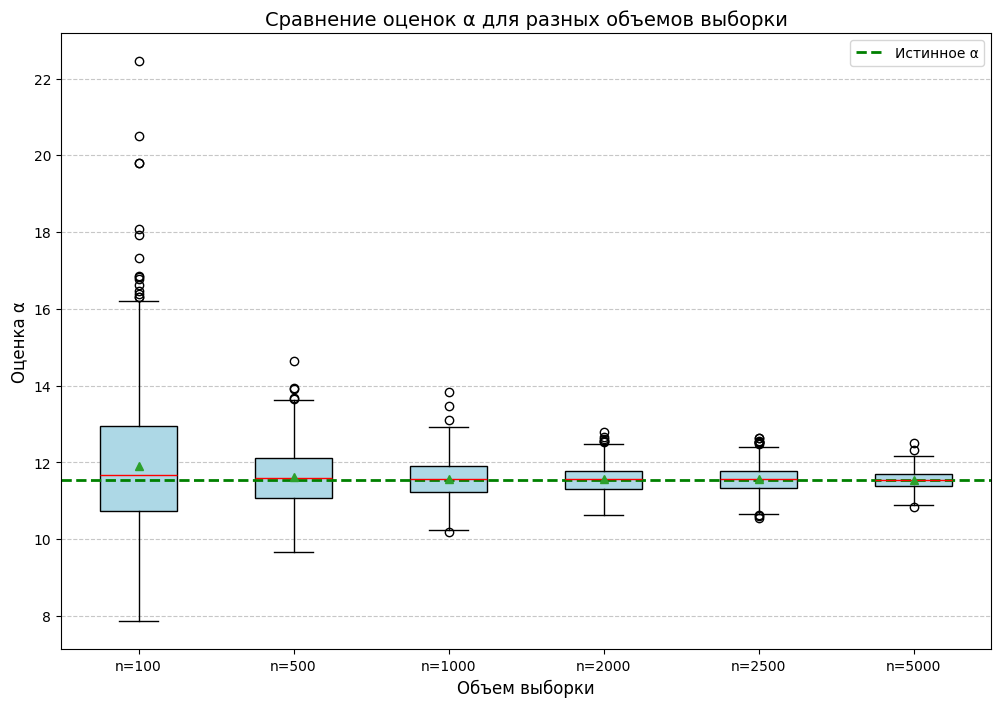

In [103]:
plt.figure(figsize=(12, 8))
plt.boxplot(
    [estimates_alpha[n] for n in n_values],
    tick_labels=[f'n={n}' for n in n_values],
    showmeans=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red')
)
plt.axhline(alpha_true, color='green', linestyle='--', linewidth=2, label='Истинное α')
plt.title('Сравнение оценок α для разных объемов выборки', fontsize=14)
plt.xlabel('Объем выборки', fontsize=12)
plt.ylabel('Оценка α', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Описательные статистики:


In [102]:
print("Описательные статистики для оценок α:")
for n in n_values:
    print(f"\nОбъем выборки: n = {n}")
    print(f"Среднее: {np.mean(estimates_alpha[n]):.4f}")
    print(f"Медиана: {np.median(estimates_alpha[n]):.4f}")
    print(f"Стандартное отклонение: {np.std(estimates_alpha[n]):.4f}")
    print(f"Минимум: {np.min(estimates_alpha[n]):.4f}")
    print(f"Максимум: {np.max(estimates_alpha[n]):.4f}")
    print(f"Смещение: {np.mean(estimates_alpha[n]) - alpha_true:.4f}")

Описательные статистики для оценок α:

Объем выборки: n = 100
Среднее: 11.9127
Медиана: 11.6739
Стандартное отклонение: 1.7402
Минимум: 7.8585
Максимум: 22.4434
Смещение: 0.3756

Объем выборки: n = 500
Среднее: 11.6121
Медиана: 11.5978
Стандартное отклонение: 0.7368
Минимум: 9.6592
Максимум: 14.6415
Смещение: 0.0750

Объем выборки: n = 1000
Среднее: 11.5772
Медиана: 11.5571
Стандартное отклонение: 0.4979
Минимум: 10.1862
Максимум: 13.8386
Смещение: 0.0400

Объем выборки: n = 2000
Среднее: 11.5588
Медиана: 11.5759
Стандартное отклонение: 0.3575
Минимум: 10.6373
Максимум: 12.7887
Смещение: 0.0216

Объем выборки: n = 2500
Среднее: 11.5700
Медиана: 11.5599
Стандартное отклонение: 0.3286
Минимум: 10.5422
Максимум: 12.6503
Смещение: 0.0329

Объем выборки: n = 5000
Среднее: 11.5458
Медиана: 11.5464
Стандартное отклонение: 0.2341
Минимум: 10.8503
Максимум: 12.5200
Смещение: 0.0087


Выполним такое же задание, только теперь вместо ММП будем использовать байесовский подход(апостериорное среднее), вместо гамма-распределения будет геометрическое $Geom(\theta)$ и параметр будет $\theta$ - вероятность успеха, также будет присутсвовать априорное распределение $Be(1,1)$

Некоторые теоретические справки:

Для выборки $X_1, X_2, \ldots, X_n$ из геометрического распределения $\text{Geom}(\theta)$ и априорного распределения $\theta \sim \text{Be}(1, 1)$, апостериорное распределение параметра $\theta$ будет:

$
\theta \,|\, X \sim \text{Be}\left(1 + n, \, 1 + \sum_{i=1}^n (X_i - 1)\right).
$

Байесовская оценка относительно среднеквадратической ошибки (апостериорное математическое ожидание):

$
\hat{\theta}_{\text{Bayes}} = \frac{1 + n}{1 + n + 1 + \sum_{i=1}^n (X_i - 1)} = \frac{n + 1}{\sum_{i=1}^n X_i + 1}.
$

Зададим параметры эксперимента:

In [109]:
n_values = [50, 100, 200, 500, 1000, 1500]
M = 1000

Создадим структуры как в прошлый раз и сделаем генерацию данных и расчёт оценок. Будет использоваться расчёт байесовской оценки выведенный раннее, а также геометрическое распределение.

In [110]:
estimates = {n: [] for n in n_values}
true_thetas = {n: [] for n in n_values}
for n in n_values:
    for _ in range(M):
        theta = np.random.beta(1, 1)
        data = np.random.geometric(p=theta, size=n)
        sum_X = np.sum(data)
        theta_hat = (n + 1) / (sum_X + 1)
        estimates[n].append(theta_hat)
        true_thetas[n].append(theta)

Расчитаем MSE:


In [111]:
mse = {n: np.mean((np.array(estimates[n]) - np.array(true_thetas[n]))**2) for n in n_values}


Визуализируем гистограммой оценки $\hat{\theta}$

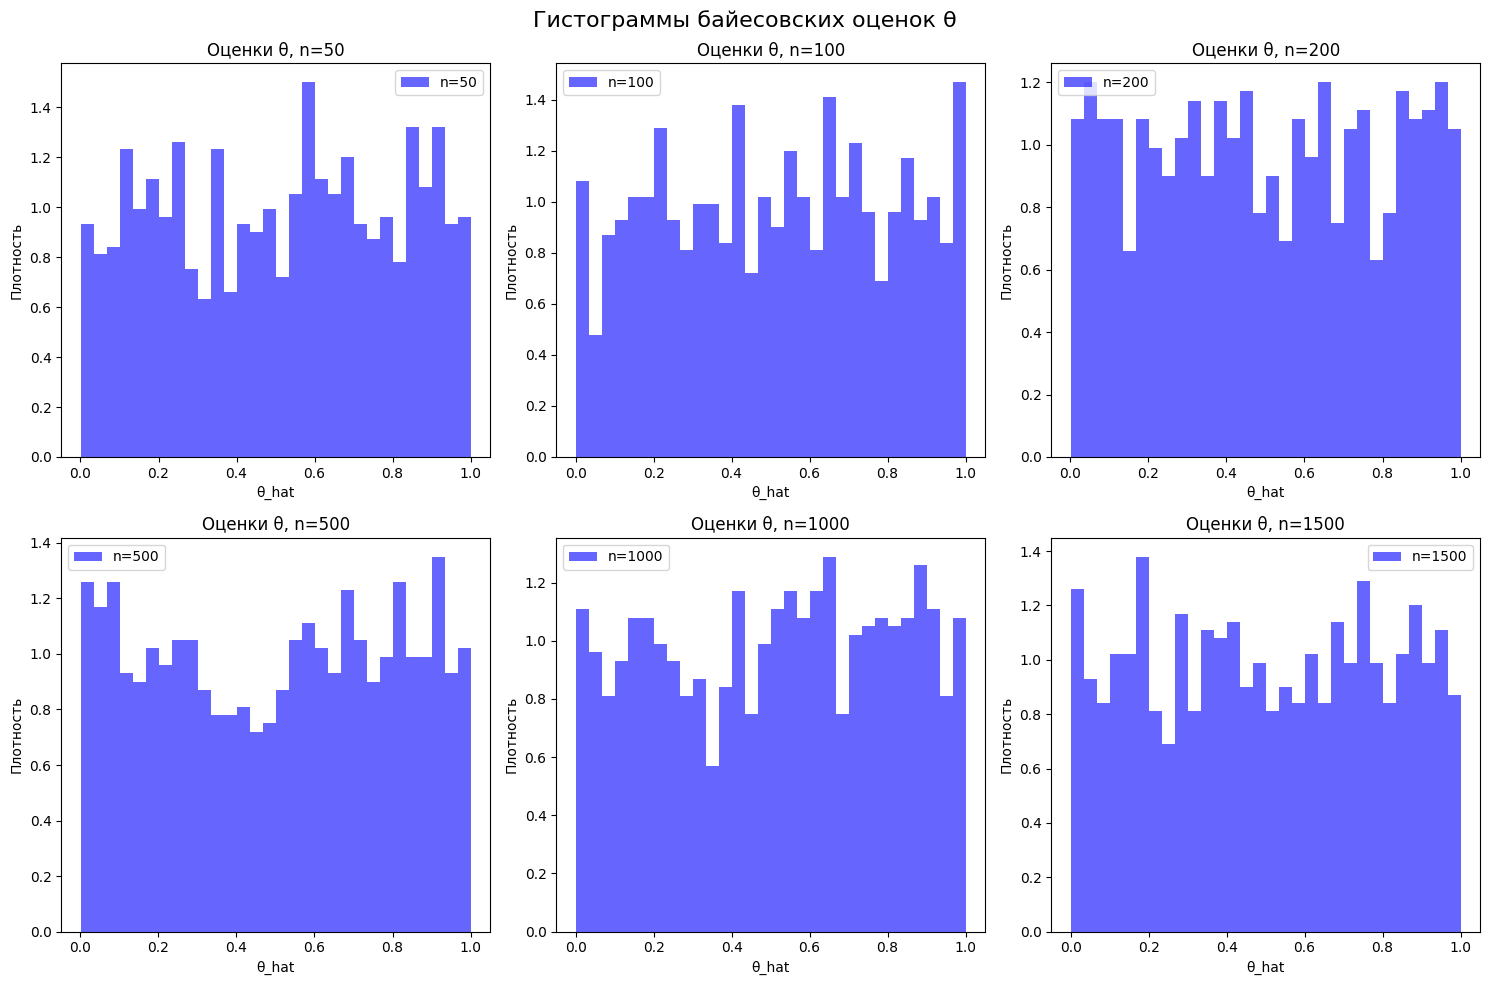

In [112]:
plt.figure(figsize=(15, 10))
for i, n in enumerate(n_values, 1):
    plt.subplot(2, 3, i)
    plt.hist(estimates[n], bins=30, density=True, alpha=0.6, color='blue', label=f'n={n}')
    plt.title(f'Оценки θ, n={n}', fontsize=12)
    plt.xlabel('θ_hat', fontsize=10)
    plt.ylabel('Плотность', fontsize=10)
    plt.legend()

plt.suptitle('Гистограммы байесовских оценок θ', fontsize=16)
plt.tight_layout()
plt.show()

box-plot оценки $\hat{\theta}$:

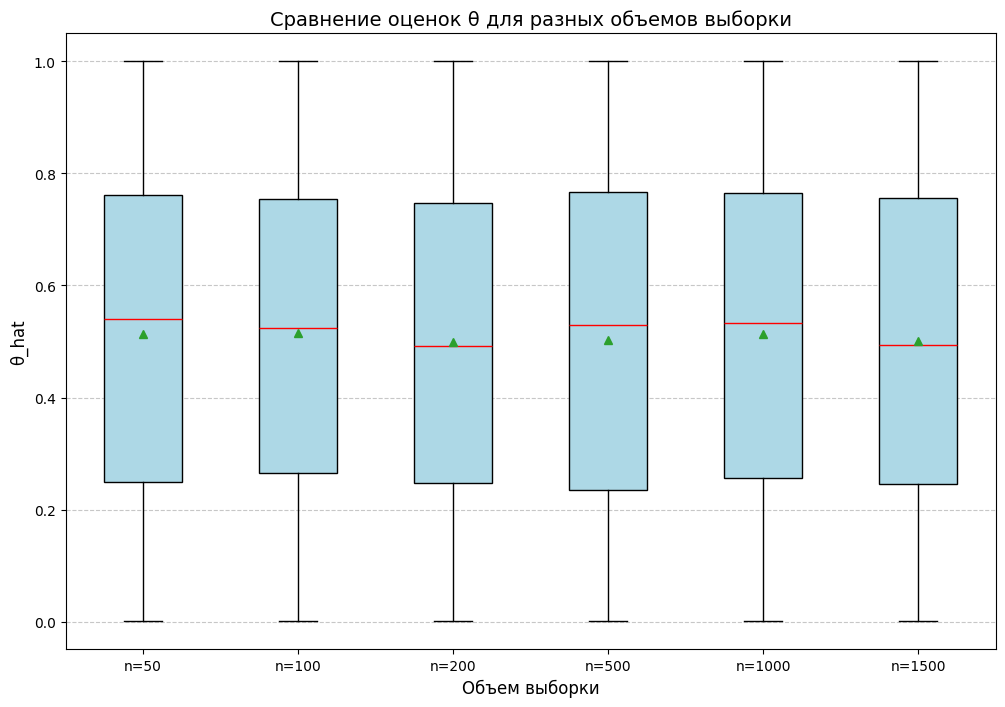

In [113]:
plt.figure(figsize=(12, 8))
plt.boxplot(
    [estimates[n] for n in n_values],
    tick_labels=[f'n={n}' for n in n_values],
    showmeans=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red')
)
plt.title('Сравнение оценок θ для разных объемов выборки', fontsize=14)
plt.xlabel('Объем выборки', fontsize=12)
plt.ylabel('θ_hat', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Выведем подсчитанное MSE:

In [114]:
print("Среднеквадратическая ошибка (MSE):")
for n in n_values:
    print(f"n = {n}: MSE = {mse[n]:.6f}")

Среднеквадратическая ошибка (MSE):
n = 50: MSE = 0.001857
n = 100: MSE = 0.000861
n = 200: MSE = 0.000394
n = 500: MSE = 0.000142
n = 1000: MSE = 0.000093
n = 1500: MSE = 0.000061
